In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
train_data = kgs.load_all_train_data()
kgs.debugging_mode = 1

In [3]:
importlib.reload(ariel_load)
loader_list = []
names = []

hole_poke = True

loaders = ariel_load.default_loaders()
for ii in range(2):
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
loaders[0].cache_steps = []
loader_list.append(copy.deepcopy(loaders))
names.append('Baseline')

if hole_poke:
    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.poke_holes = True
    loader_list.append(copy.deepcopy(loaders))
    names.append('Introduce hole')

# for ii in range(2):
#     loaders[ii].apply_full_sensor_corrections.remove_background_remove_used_rows = False   
# loader_list.append(copy.deepcopy(loaders))
# names.append('Baseline with bad rows')

for ii in range(2):
    loaders[ii].apply_full_sensor_corrections.remove_background_remove_used_rows = False
    loaders[ii].apply_wavelength_binning = ariel_load.ApplyWavelengthBinning2()
loaders[0].apply_wavelength_binning.options.n_components = 4
loaders[1].apply_wavelength_binning.options.n_components = 3
loader_list.append(copy.deepcopy(loaders))
names.append('New with inpainting')

for ii in range(2):
    loaders[ii].apply_full_sensor_corrections.inpainting_2d = False
    loaders[ii].apply_full_sensor_corrections.inpainting_wavelength = False
loader_list.append(copy.deepcopy(loaders))
names.append('New w/o inpainting')

# loaders[1].apply_wavelength_binning.options.n_components = 1
# loader_list.append(copy.deepcopy(loaders))
# names.append('New w/o inpainting 1 comp')

model = ariel_gp.PredictionModel()
model.plot_final = True
model.train(train_data)

0


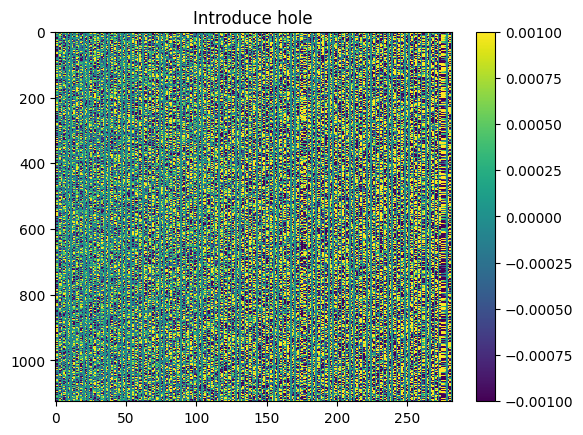

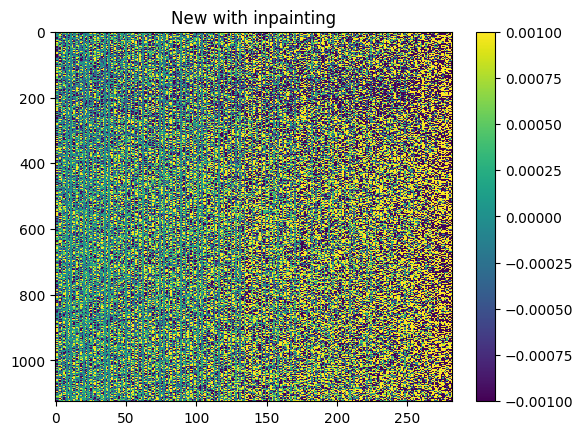

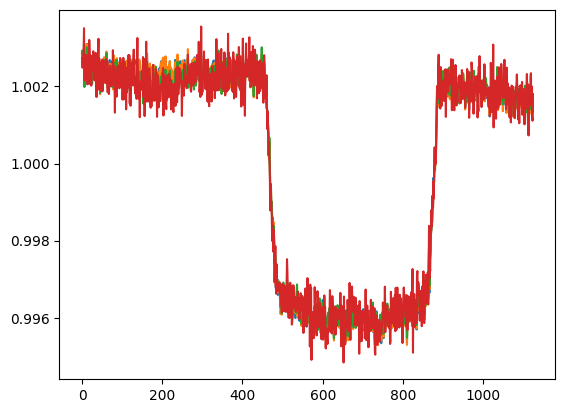

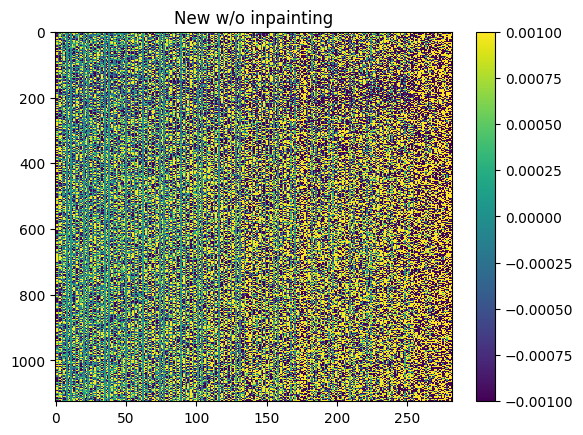

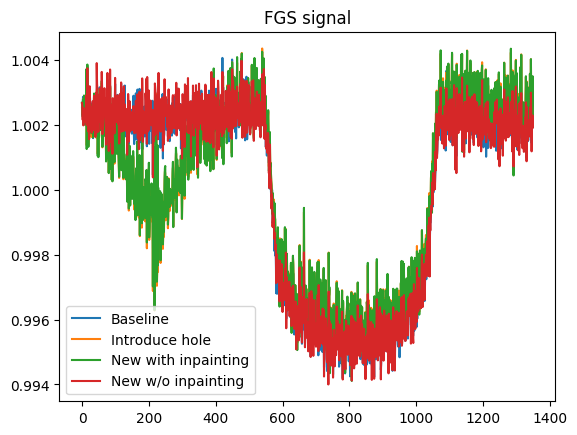

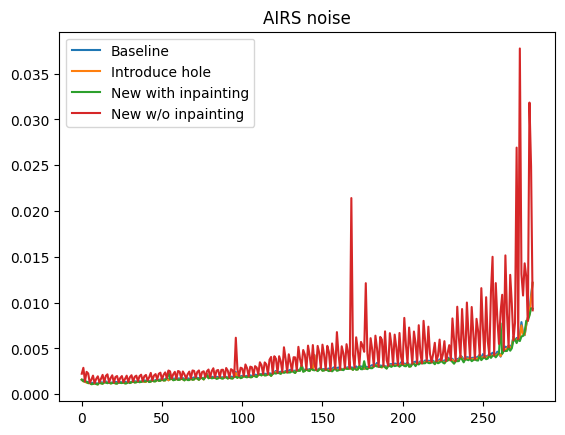

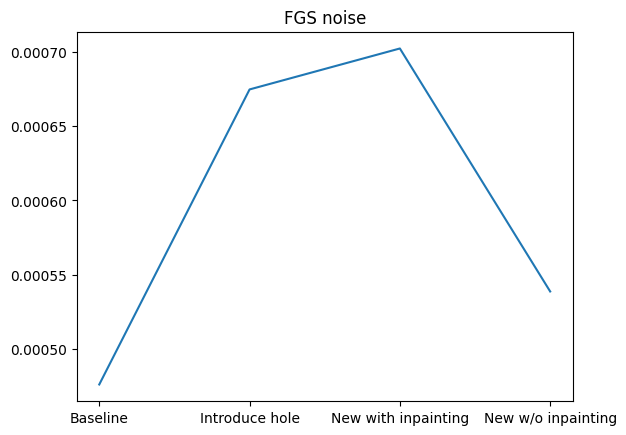

In [4]:
for ii,d in enumerate(train_data[5:6]):
    print(ii)
    d=copy.deepcopy(d)
    fig_fgs_noise = plt.figure()
    fig_fgs_sig = plt.figure()    
    fig_airs_noise = plt.figure()
    fig_airs_sig=  plt.figure()
    fgs_noise_vals = []
    for j,load in enumerate(loader_list):
        d.load_to_step(0,load)
        d.load_to_step(5,load)
        
        fgs_sig = copy.deepcopy(d.transits[0].data[0].data)
        fgs_sig = fgs_sig/kgs.rms(fgs_sig)
        fgs_noise_vals.append(ariel_numerics.estimate_noise_cp(fgs_sig).get())
        plt.figure(fig_fgs_sig)
        plt.plot(fgs_sig.get())
        
        airs_sig = copy.deepcopy(d.transits[0].data[1].data)
        for ii in range(airs_sig.shape[1]):
            airs_sig[:,ii]/=kgs.rms(airs_sig[:,ii])
        plt.figure(fig_airs_sig)
        plt.plot(cp.mean(airs_sig,1).get())            
        plt.figure(fig_airs_noise)
        plt.plot(ariel_numerics.estimate_noise_cp(airs_sig).get())
        
        if j==0:
            baseline_airs = airs_sig
        else:
            plt.figure()
            plt.imshow((airs_sig-baseline_airs).get(), aspect='auto', interpolation = 'none')
            plt.title(names[j])
            plt.colorbar()
            plt.clim([-1e-3,1e-3])
            
        #model.infer([d])
        
        d.load_to_step(0,load)
    plt.figure(fig_fgs_sig)
    plt.legend(names)
    plt.title('FGS signal')
    plt.figure(fig_airs_noise)
    plt.legend(names)
    plt.title('AIRS noise')
    plt.figure(fig_fgs_noise)
    plt.title('FGS noise')
    plt.plot(fgs_noise_vals)
    plt.xticks(np.arange(len(names)), names)
    #plt.xticks(names)
    plt.pause(0.001)

In [5]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [6]:
loader_list[1]

[TransitLoader(comment='', cache_steps=[5], load_raw_data=LoadRawData(comment=''), apply_pixel_corrections=ApplyPixelCorrections(comment=''), apply_full_sensor_corrections=ApplyFullSensorCorrections(comment=''), apply_time_binning=ApplyTimeBinning(comment=''), apply_wavelength_binning=ApplyWavelengthBinning(comment='')),
 TransitLoader(comment='', cache_steps=[5], load_raw_data=LoadRawData(comment=''), apply_pixel_corrections=ApplyPixelCorrections(comment=''), apply_full_sensor_corrections=ApplyFullSensorCorrections(comment=''), apply_time_binning=ApplyTimeBinning(comment=''), apply_wavelength_binning=ApplyWavelengthBinning(comment=''))]

In [ ]:
for d in train_data[1:2]:
    d=copy.deepcopy(d)
    fig_fgs_noise = plt.figure()
    fig_fgs_sig = plt.figure()    
    fig_airs_noise = plt.figure()
    fig_airs_sig=  plt.figure()
    fgs_noise_vals = []
    for j,load in enumerate(loader_list):
        
        model.infer([d])
        
        d.load_to_step(0,load)
    plt.figure(fig_fgs_sig)
    plt.legend(names)
    plt.title('FGS signal')
    plt.figure(fig_airs_noise)
    plt.legend(names)
    plt.title('AIRS noise')
    plt.figure(fig_fgs_noise)
    plt.title('FGS noise')
    plt.plot(fgs_noise_vals)
    plt.xticks(np.arange(len(names)), names)
    #plt.xticks(names)
    plt.pause(0.001)

{'main': CompoundNamed(comment='.signal.main')}
